In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [59]:
exchange_data = pd.read_csv('AUW1.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Change %
0,"Nov 07, 2021",0.7332,0.7394,0.7432,0.7276,-0.93%
1,"Oct 31, 2021",0.7401,0.7509,0.7538,0.7359,-1.60%
2,"Oct 24, 2021",0.7521,0.7468,0.7556,0.7461,0.76%
3,"Oct 17, 2021",0.7464,0.7422,0.7548,0.7378,0.58%
4,"Oct 10, 2021",0.7421,0.7314,0.7441,0.7291,1.57%


In [60]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [61]:
ind_exchange_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2021-11-07,0.7332,0.7394,0.7432,0.7276,-0.93%
2021-10-31,0.7401,0.7509,0.7538,0.7359,-1.60%
2021-10-24,0.7521,0.7468,0.7556,0.7461,0.76%
2021-10-17,0.7464,0.7422,0.7548,0.7378,0.58%
2021-10-10,0.7421,0.7314,0.7441,0.7291,1.57%


In [62]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.dropna()
data_frame.head()

,Change %,High,Low,Open,Price
Date,,,,,
2008-11-16,-2.81%,0.6598,0.6073,0.6382,0.6306
2008-11-23,3.89%,0.6619,0.6230,0.6322,0.6551
2008-11-30,-1.19%,0.6538,0.6289,0.6529,0.6473
2008-12-07,2.30%,0.6802,0.6455,0.6481,0.6622
2008-12-14,3.11%,0.7142,0.6610,0.6636,0.6828


<AxesSubplot:xlabel='Date'>

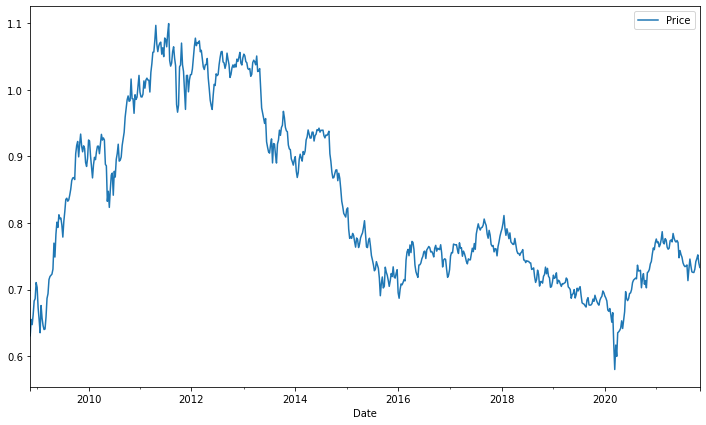

In [63]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [64]:
diff = df.index.values[-1] - df.index.values[0]

days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 12 years
80 percent data = 2010 to 2019


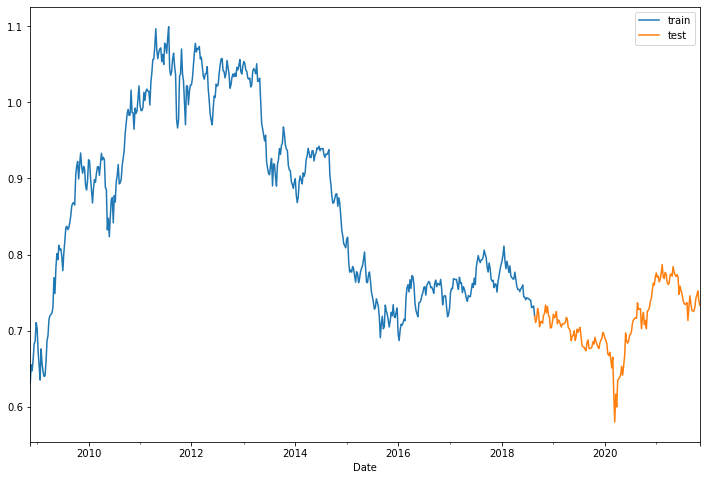

In [65]:
split_date = pd.Timestamp('26-08-2018')
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [66]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [67]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [68]:
print(X_train.shape)
print(X_test.shape)


(510, 1)
(167, 1)


In [69]:
X_train[:5]

array([[-1.94922495],
       [-1.74870859],
       [-1.81254646],
       [-1.69059977],
       [-1.52200235]])

In [70]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
n_input = 5 
n_features = 1
generator = TimeseriesGenerator(X_train, X_train, length = n_input, batch_size = 1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.74747248 -1.75279084 -1.76209797 -1.76941072 -1.80796883]
Predict this y: 
 [[-1.82791268]]


In [18]:
X.shape

(1, 5, 1)

In [19]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(n_input, n_features), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:

model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model_lstm.fit(generator,epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
2069/2069 [==============================] - 3s 2ms/step - loss: 0.0037 - rmse: 0.0606
Epoch 2/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0073 - rmse: 0.0854
Epoch 3/50
2069/2069 [==============================] - 3s 2ms/step - loss: 0.0033 - rmse: 0.0577
Epoch 4/50
2069/2069 [==============================] - 3s 2ms/step - loss: 0.0034 - rmse: 0.0584
Epoch 5/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0030 - rmse: 0.0544
Epoch 6/50
2069/2069 [==============================] - 3s 2ms/step - loss: 0.0025 - rmse: 0.0505
Epoch 7/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0023 - rmse: 0.0481
Epoch 8/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0021 - rmse: 0.0463
Epoch 9/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 10/50
2069/2069 [==============================] - 3s 1ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 11/50
2069/20

In [23]:
last_train_batch = X_train[-5:]

In [24]:

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [25]:
model_lstm.predict(last_train_batch)

array([[1.4178758]], dtype=float32)

In [26]:

X_test[0]

array([1.42426453])

In [27]:
test_predictions = []

In [28]:
first_eval_batch = X_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model_lstm.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [29]:
test_predictions

[array([1.4178758], dtype=float32),
 array([1.426188], dtype=float32),
 array([1.4309281], dtype=float32),
 array([1.4383351], dtype=float32),
 array([1.4365704], dtype=float32),
 array([1.4341446], dtype=float32),
 array([1.4296914], dtype=float32),
 array([1.4253186], dtype=float32),
 array([1.4193443], dtype=float32),
 array([1.4143027], dtype=float32),
 array([1.4102987], dtype=float32),
 array([1.4079375], dtype=float32),
 array([1.4068003], dtype=float32),
 array([1.4071889], dtype=float32),
 array([1.4087366], dtype=float32),
 array([1.4111214], dtype=float32),
 array([1.4138166], dtype=float32),
 array([1.4165077], dtype=float32),
 array([1.418832], dtype=float32),
 array([1.4205592], dtype=float32),
 array([1.42154], dtype=float32),
 array([1.4217786], dtype=float32),
 array([1.4213511], dtype=float32),
 array([1.4204116], dtype=float32),
 array([1.4191514], dtype=float32),
 array([1.4177825], dtype=float32),
 array([1.4164943], dtype=float32),
 array([1.4154382], dtype=float3

In [38]:
new_y_pred = test_predictions
prediction_for_plot = []

X_new = np.asarray(new_y_pred)

for i in range(5):
    
    X_new = np.reshape(X_new, (X_test.shape[0] + 1,  1, X_test.shape[1]))
    
    predicted_values = model_lstm.predict(X_new)
    
    new_return = sc.inverse_transform(predicted_values)
    print(new_return[-1])

    X_new = np.delete(X_new, 0)
    
    X_new = np.append(X_new, new_return[-1])
    X_new = np.asarray(X_new)
    
    
    

[73.93401]
[914.97363]
[10671.166]
[123826.34]
[1436233.1]


In [31]:
true_predictions = sc.inverse_transform(X_new)

In [32]:
true_predictions

array([[70.11695 ],
       [70.17947 ],
       [70.21512 ],
       [70.27083 ],
       [70.25755 ],
       [70.23931 ],
       [70.20582 ],
       [70.17293 ],
       [70.128   ],
       [70.09007 ],
       [70.05996 ],
       [70.042206],
       [70.03365 ],
       [70.036575],
       [70.04821 ],
       [70.06615 ],
       [70.08642 ],
       [70.10666 ],
       [70.12414 ],
       [70.13713 ],
       [70.14451 ],
       [70.1463  ],
       [70.14309 ],
       [70.136024],
       [70.12654 ],
       [70.11625 ],
       [70.10656 ],
       [70.09862 ],
       [70.09316 ],
       [70.09053 ],
       [70.09063 ],
       [70.09304 ],
       [70.09711 ],
       [70.10207 ],
       [70.10717 ],
       [70.111725],
       [70.11526 ],
       [70.117455],
       [70.11824 ],
       [70.11773 ],
       [70.11617 ],
       [70.11393 ],
       [70.11139 ],
       [70.10892 ],
       [70.10681 ],
       [70.10529 ],
       [70.10446 ],
       [70.104324],
       [70.10479 ],
       [70.10572 ],


In [34]:
plt.figure(figsize=(12,8))
plt.plot(x_train, label='True')
plt.plot(true_predictions, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


NameError: name 'x_train' is not defined

<Figure size 864x576 with 0 Axes>